In [1]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision
from torchvision import transforms
from torchvision.datasets.vision import VisionDataset
from torchvision.transforms import ToTensor,Resize, Grayscale, Normalize
import matplotlib.pyplot as plt
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import pandas as pd
from torch.utils.data import Dataset
import glob
import cv2
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

try:
    from google.colab import drive
    drive.mount('/content/gdrive')

    import zipfile
    import os
    zip_file = "/content/gdrive/MyDrive/base_v2.1.zip"
    z = zipfile.ZipFile(zip_file, 'r')
    z.extractall()
    print('Load dataset from Google Drive done!')
except:
    # This import also use in detect_nn.py
    # If you want change torch model, change model.py
    from model import CNN, transforms
    print('CNN, transforms loaded from local model.py.')
else:
    !rm model.py
    !wget https://raw.githubusercontent.com/EPC-MSU/epdetection/dev-1.5/detection/utilities/model.py
    from model import CNN, transforms
    print('Load dataset from Google Drive done!')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Mounted at /content/gdrive
Load dataset from Google Drive done!
rm: cannot remove 'model.py': No such file or directory
--2022-07-29 11:40:08--  https://raw.githubusercontent.com/EPC-MSU/epdetection/dev-1.5/detection/utilities/model.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1637 (1.6K) [text/plain]
Saving to: ‘model.py’

model.py            100%[===================>]   1.60K  --.-KB/s    in 0s      

2022-07-29 11:40:08 (22.0 MB/s) - ‘model.py’ saved [1637/1637]

Load dataset from Google Drive done!
Using device: cuda


In [2]:
class PCBDataset(Dataset):
    def __init__(self, classes_paths, transforms=None, target_transform=None):
        #print(glob.glob(data_dir))
        self.classes = []
        self.classes_paths = classes_paths
        self.images = []
        self.transform = transforms
        for actual_class in classes_paths:
            if actual_class == 1:
                print("")
            paths = classes_paths[actual_class]
            for path in paths:
                # print("Loading " + path)
                for top, dirs, files in os.walk(path):
                    for i, name in enumerate(files):
                        if not os.path.isfile(top + "//" + name):
                            continue
                        try:
                            imag = cv2.imread(top + "//" + name)
                        except Exception:
                            continue
                        self.images.append(imag)
                        self.classes.append(actual_class)
        self.images = np.array(self.images, dtype=object)
        self.classes = torch.tensor(np.array(self.classes), dtype=torch.int64)
        self.plot_disbalance()


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if self.transform==None:
            return self.images[idx], self.classes[idx]
        else:
            return self.transform(np.array(self.images[idx]).astype(np.float32)), self.classes[idx]
        
    def plot_disbalance(self):
        heights = []
        labels = []
        incorrect_sum = 0
        for path in self.classes_paths[0]:
            incorrect_sum += len(glob.glob(os.path.join(path, '*')))
        heights.append(incorrect_sum)
        labels.append('incorrect')
        for i in range(1, len(self.classes_paths)-1, 1):
            path = os.path.normpath(self.classes_paths[i][0])
            labels.append(path.split(os.sep)[2])
            heights.append(len(glob.glob(os.path.join(self.classes_paths[i][0], '*'))))
        plt.bar(range(len(heights)), heights)
        plt.ylabel('count images')
        plt.xticks(range(len(heights)), labels, rotation='vertical')
        plt.show()

#### Help functions

In [3]:
def validate(model,testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

def validate_by_class(model, dataset_test):
    acc_by_class = {}
    with torch.no_grad():
        model.eval()
        for image, label in dataset_test:
            outputs = model(image.unsqueeze(0))
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted.squeeze() == label).sum().item()
            
            if int(label) not in acc_by_class:
                acc_by_class[int(label)] = (correct, 1)
            if int(label) in acc_by_class:
                correct_prev, total_prev = acc_by_class[int(label)]
                acc_by_class[int(label)] = (correct_prev + correct, total_prev + 1)
    for key in CLASSES_PATHS.keys():
        path = CLASSES_PATHS[key]
        label = os.path.normpath(path[0])
        label = label.split(os.sep)[2]
        try:
            correct, total = acc_by_class[key]
            s = (20 - len(label))*' '
            print(label, s + f'acc: {correct}/{total}')
        except:
            print(label, (20 - len(label))*' ' + 'NOT FOUND')

#### Train

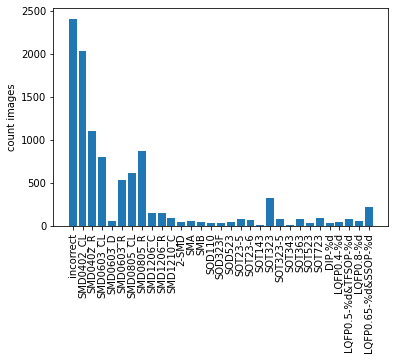

In [4]:
CLASSES_PATHS = {
    0: ["base_v2.1//train_x1//2-SMD//incorrect",
        "base_v2.1//train_x1//SMA//incorrect",
        "base_v2.1//train_x1//SMB//incorrect",
#         "base_v2.1//train_x1//SOD110//incorrect",
#             "base_v2.1//train_x1//SOD323F//incorrect",
#             "base_v2.1//train_x1//SOD523//incorrect",
#             "base_v2.1//train_x1//SOT23-5//incorrect",
#             "base_v2.1//train_x1//SOT23-6//incorrect",
#             "base_v2.1//train_x1//SOT143//incorrect",
#             "base_v2.1//train_x1//SOT323//incorrect",
#             "base_v2.1//train_x1//SOT323-5//incorrect",
#             "base_v2.1//train_x1//SOT343//incorrect",
#             "base_v2.1//train_x1//SOT363//incorrect",
#             "base_v2.1//train_x1//SOT523//incorrect",
#             "base_v2.1//train_x1//SOT723//incorrect",
#             "base_v2.1//train_x1//SMD0402_CL//incorrect",
#             "base_v2.1//train_x1//SMD0402_R//incorrect",
#             "base_v2.1//train_x1//SMD0603_CL//incorrect",
#             "base_v2.1//train_x1//SMD0603_D//incorrect",
#             "base_v2.1//train_x1//SMD0603_R//incorrect",
#             "base_v2.1//train_x1//SMD0805_CL//incorrect",
#         "base_v2.1//train_x1//SMD0805_R//incorrect",
        "base_v2.1//train_x1//SMD1206_C//incorrect",
        "base_v2.1//train_x1//SMD1206_R//incorrect",
        "base_v2.1//train_x1//SMD1210_C//incorrect"],
    1: ["base_v2.1//train_x1//SMD0402_CL//correct"],
    2: ["base_v2.1//train_x1//SMD0402_R//correct"],
    3: ["base_v2.1//train_x1//SMD0603_CL//correct"],
    4: ["base_v2.1//train_x1//SMD0603_D//correct"],
    5: ["base_v2.1//train_x1//SMD0603_R//correct"],
    6: ["base_v2.1//train_x1//SMD0805_CL//correct"],
    7: ["base_v2.1//train_x1//SMD0805_R//correct"],
    8: ["base_v2.1//train_x1//SMD1206_C//correct"],
    9: ["base_v2.1//train_x1//SMD1206_R//correct"],
    10: ["base_v2.1//train_x1//SMD1210_C//correct"],
    11: ["base_v2.1//train_x1//2-SMD//correct"],
    12: ["base_v2.1//train_x1//SMA//correct"],
    13: ["base_v2.1//train_x1//SMB//correct"],
    14: ["base_v2.1//train_x1//SOD110//correct"],
    15: ["base_v2.1//train_x1//SOD323F//correct"],
    16: ["base_v2.1//train_x1//SOD523//correct"],
    17: ["base_v2.1//train_x1//SOT23-5//correct"],
    18: ["base_v2.1//train_x1//SOT23-6//correct"],
    19: ["base_v2.1//train_x1//SOT143//correct"],
    20: ["base_v2.1//train_x1//SOT323//correct"],
    21: ["base_v2.1//train_x1//SOT323-5//correct"],
    22: ["base_v2.1//train_x1//SOT343//correct"],
    23: ["base_v2.1//train_x1//SOT363//correct"],
    24: ["base_v2.1//train_x1//SOT523//correct"],
    25: ["base_v2.1//train_x1//SOT723//correct"],
    26: ["base_v2.1//train_x1//DIP-%d//correct"],
    27: ["base_v2.1//train_x1//LQFP0.4-%d//correct"],
    28: ["base_v2.1//train_x1//LQFP0.5-%d&TFSOP-%d//correct"],
    29: ["base_v2.1//train_x1//LQFP0.8-%d//correct"],
    30: ["base_v2.1//train_x1//LQFP0.65-%d&SSOP-%d//correct"],
    31: ["base_v2.1//train_x1//SOIC-%d//correct"]
}

dataset = PCBDataset(CLASSES_PATHS, transforms)

In [5]:
def train(model, loss_function, optimizer, epochs):
    loss_hist = []
    test_accuracy = []
    train_accuracy = []
    for epoch in range(epochs):
        ep_loss = 0
        for images, labels in  tqdm(train_loader): # get bacth
            optimizer.zero_grad() # sets the gradients of all optimized tensors to zero.
            outputs = model.forward(images) # call forward inside
            loss = loss_function(outputs, labels) # calculate loss
            loss.backward() # calculate gradients
            optimizer.step() # performs a single optimization step (parameter update).
            ep_loss += loss.item()
        loss_hist.append(ep_loss /len(train_loader))
        print(f"Epoch={epoch} loss={loss_hist[epoch]:.4}")
        test_accuracy.append(validate(model, test_loader))
        train_accuracy.append(validate(model, train_loader))
    return test_accuracy,train_accuracy, loss_hist

In [6]:
dataset_train, dataset_test = torch.utils.data.random_split(dataset, [int(len(dataset) * 0.9),
                                                                      len(dataset) - int(len(dataset) * 0.9)])
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False)

In [7]:
model = CNN()
EPOCHS = 10
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss().cuda()

torch.Size([1, 512])


In [8]:
test_accuracy, train_accuracy, loss_hist = train(model, criterion, optimizer, epochs=EPOCHS)

100%|██████████| 298/298 [00:12<00:00, 23.01it/s]


Epoch=0 loss=0.8779


100%|██████████| 298/298 [00:12<00:00, 24.11it/s]


Epoch=1 loss=0.3818


100%|██████████| 298/298 [00:12<00:00, 22.96it/s]


Epoch=2 loss=0.2622


100%|██████████| 298/298 [00:12<00:00, 23.87it/s]


Epoch=3 loss=0.2014


100%|██████████| 298/298 [00:12<00:00, 23.63it/s]


Epoch=4 loss=0.1599


100%|██████████| 298/298 [00:12<00:00, 23.56it/s]


Epoch=5 loss=0.1196


100%|██████████| 298/298 [00:12<00:00, 24.09it/s]


Epoch=6 loss=0.1053


100%|██████████| 298/298 [00:12<00:00, 23.95it/s]


Epoch=7 loss=0.07529


100%|██████████| 298/298 [00:12<00:00, 24.04it/s]


Epoch=8 loss=0.07876


100%|██████████| 298/298 [00:12<00:00, 24.12it/s]


Epoch=9 loss=0.07957


In [9]:
validate(model, test_loader)

0.9130434782608695

In [10]:
validate_by_class(model, dataset_test)

2-SMD                acc: 255/265
SMD0402_CL           acc: 179/182
SMD0402_R            acc: 106/109
SMD0603_CL           acc: 68/75
SMD0603_D            acc: 4/7
SMD0603_R            acc: 52/57
SMD0805_CL           acc: 44/58
SMD0805_R            acc: 95/98
SMD1206_C            acc: 12/14
SMD1206_R            acc: 15/19
SMD1210_C            acc: 7/8
2-SMD                acc: 3/3
SMA                  acc: 4/6
SMB                  acc: 3/7
SOD110               acc: 2/4
SOD323F              acc: 3/5
SOD523               acc: 3/4
SOT23-5              acc: 9/11
SOT23-6              acc: 8/11
SOT143               acc: 2/2
SOT323               acc: 28/38
SOT323-5             acc: 9/10
SOT343               acc: 0/2
SOT363               acc: 2/4
SOT523               acc: 6/7
SOT723               acc: 5/5
DIP-%d               acc: 7/7
LQFP0.4-%d           acc: 5/6
LQFP0.5-%d&TFSOP-%d  acc: 9/12
LQFP0.8-%d           acc: 6/6
LQFP0.65-%d&SSOP-%d  acc: 19/26
SOIC-%d              acc: 22/22


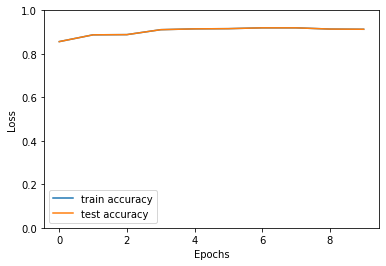

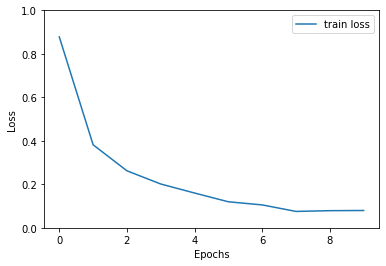

In [11]:
plt.plot(range(EPOCHS), train_accuracy, label='train accuracy')
plt.plot(range(EPOCHS), test_accuracy, label='test accuracy')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim([0, 1])
plt.legend()
plt.show()

plt.plot(range(EPOCHS), loss_hist, label='train loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim([0, 1])
plt.legend()
plt.show()

#### Save model and try to load

Эта сложная конструкция ниже предназначена для сохранения нейронки и файла с метаинформацией, по которой можно правильно загрузить нейронку в epdetection

In [14]:
!pip install jsonpickle
import json
import jsonpickle
try:
    from model_info.model_info import ModelInfo
    print('ModelInfo loaded from local model_info.py')
except:
    !mkdir model_info
    !wget https://raw.githubusercontent.com/EPC-MSU/epdetection/dev-1.5/detection/utilities/model_info/compatible_det_info.json -O model_info/compatible_det_info.json
    !wget https://raw.githubusercontent.com/EPC-MSU/epdetection/dev-1.5/detection/utilities/model_info/model_info.py -O model_info/model_info.py
    from model_info.model_info import ModelInfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ModelInfo loaded from local model_info.py


In [15]:
with open("model_info/compatible_det_info.json") as f:
    model_info = ModelInfo("Andrey Marakulin", json.load(f))
    model_info.compile_info()
    model_info.save_info()
    model_name = model_info.get_info()['modelname']
    
torch.save(model.state_dict(), model_name)

Info saved in:  ./model_2022-07-29.pth.json


In [16]:
# Simple test
model_test = CNN()
model_test.load_state_dict(torch.load(model_name))
model_test.eval()
model_test(dataset[8000][0].unsqueeze(dim=0))


torch.Size([1, 512])


tensor([[ -2.3761,  -4.9783,  -7.4083,  -8.8340,  -4.9367,  -2.0664,  -5.1833,
           9.0426,  -9.0857,  -2.7196, -12.6605,  -7.6325,  -8.6459, -12.8568,
          -7.6253,  -9.1043,  -9.3834, -10.8187,  -8.5232,  -8.2161, -11.7389,
          -9.0249,  -7.9422,  -8.0351, -10.5964, -13.4063,  -7.7492,  -8.1755,
          -9.0000,  -9.5322,  -6.4565,  -4.0244]], grad_fn=<AddmmBackward0>)